In [21]:
from skimage.color import rgb2ycbcr, ycbcr2rgb, rgb2lab, rgb2gray
from skimage.transform import resize
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from skimage.io import imread


from scipy.fftpack import dct
from skimage.metrics import peak_signal_noise_ratio as PSNR

def sub2ind(n_row, row, col):
  return n_row * col + row

def dctmtx(N):
  return dct(np.eye(N), norm='ortho', axis=0)

def func(x, mat):
  return mat @ x @ mat.T

def func1(x, mat):
  return np.multiply(mat, x)

def blockproc(im, mat, block_sz, func):
    h, w = im.shape
    m, n = block_sz
    im_out = np.zeros_like(im)
    for x in range(0, h, m):
        for y in range(0, w, n):
            block = im[x:x+m, y:y+n]
            im_out[x:x+m, y:y+n] = func(block, mat)
    return im_out

# 2. Chroma Subsampling

In [33]:
peppers = imread('peppers.png').astype(np.float64)/255
print(peppers.shape)

(384, 512, 3)


22.5992 235.0
Y


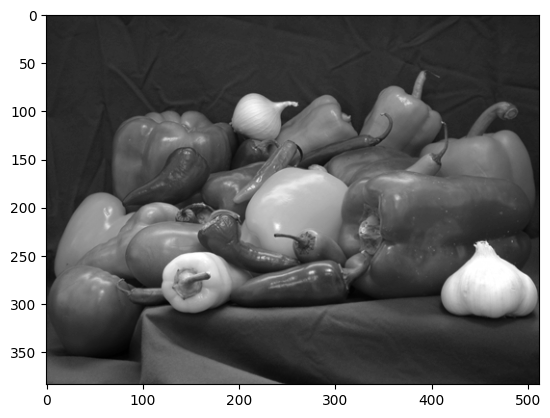

Cb


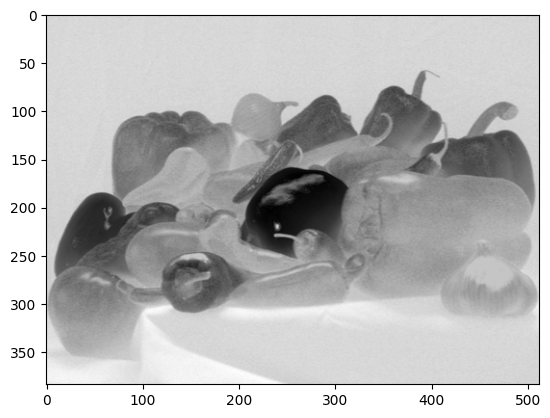

Cr


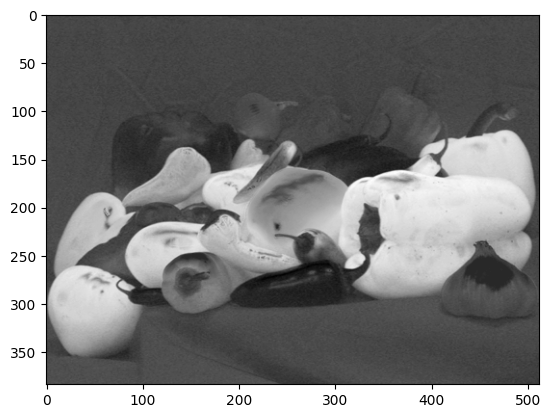

In [39]:
peppers_ycbcr = rgb2ycbcr(peppers)
print(np.min(peppers_ycbcr), np.max(peppers_ycbcr))

y, cb, cr = peppers_ycbcr[:,:,0], peppers_ycbcr[:,:,1], peppers_ycbcr[:,:,2]
for i, channel in enumerate(['Y', 'Cb', 'Cr']):
    print(channel)
    plt.imshow(peppers_ycbcr[:,:,i], cmap='gray')
    plt.show()

22.5992 235.0
29.961087009803922 155.60558799019606
113.52605196078432 211.75055294117647


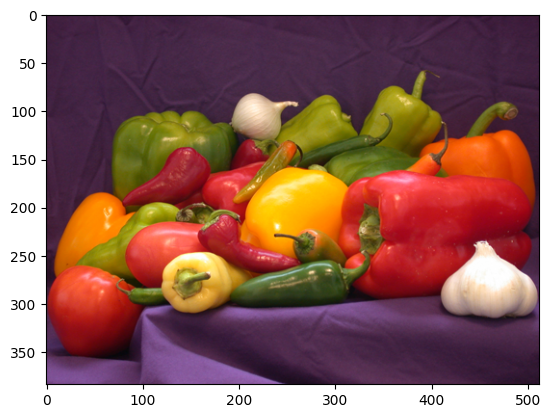

In [43]:
# Resize Cb and Cr channels
cb_subsampled = resize(cb[::2, ::2], cb.shape)
cr_subsampled = resize(cr[::2, ::2], cr.shape)
peppers_subsampled = np.copy(peppers_ycbcr)
peppers_subsampled[:,:,1] = cb_subsampled
peppers_subsampled[:,:,2] = cr_subsampled
plt.imshow(np.clip(ycbcr2rgb(peppers_ycbcr), 0, 1))
plt.show()